### Breaking up tanh and exercising more operations
- tanh developed as a single function because we know the derivative.
- tanh can be broken down and express it as a function of x
- implement more operations: exponentiation, addition, division etc

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

  def __init__(self,data, _children=(), _operation='', label=''):
    self.data = data
    self.grad = 0.0 #gradient initialized as 0
    self._backward = lambda : None
    self._prev = set(_children) #empty set
    self._operation = _operation
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only support int/float powers for now"
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad #chain rule
    out._backward = _backward
    return out

  def __radd__(self, other): #other + self
    return self + other

  def __rmul__(self, other): #other * self
    return self * other

  def __truediv__(self, other): #self/other
    return self * other**-1

  def __neg__(self): #-self
    return self * -1

  def __sub__(self, other): #self - other
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out


  def backward(self):
    # implement topological sort
    top_sort = []
    visited = set()

    def build_top_sort(v):
      if v is not visited:
        visited.add(v)
        for child in v._prev:
          build_top_sort(child)
        top_sort.append(v) #add node to list only after children are processed
    build_top_sort(self)

    self.grad = 1.0
    for node in reversed(top_sort):
      node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
  # builds set of nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create rectangular ('record') node
    dot.node (name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._operation:
      # if this value is a result of operation, create operation node
      dot.node(name = uid + n._operation, label=n._operation)
      # and connect this node to it
      dot.edge(uid + n._operation, uid)

  for n1, n2, in edges:
    # connect n1 to the operation node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot


In [4]:
# inputs: x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.8813735870195432, label = 'b')

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'

# n : without activation
n = x1w1_x2w2 + b; n.label='n'

# actiavtion function
o = n.tanh(); o.label='o'

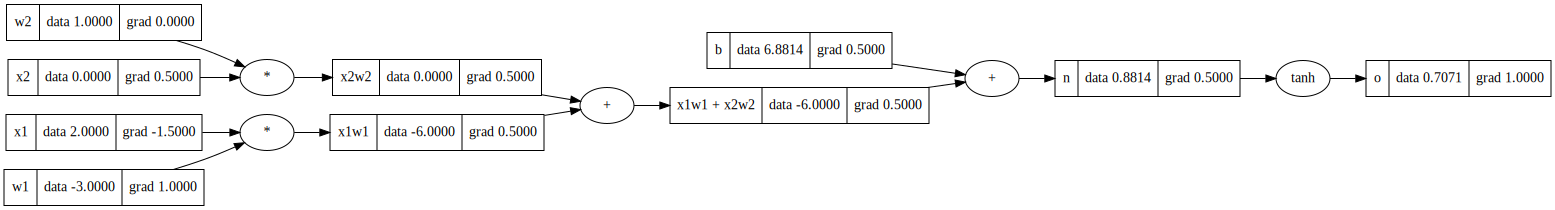

In [5]:
o.backward()
draw_dot(o)


### Implementing more mathematical expressions

ADDITION:
> `a = Value(2.0)`\
`a + 1` (doesnt work, because 1 is not a value object)

Solution: wrap number in `Value` object





In [6]:
a = Value(2.0)
a + 1

Value(data=3.0)

MULTIPLICATION:
> `a * 2` (works: `a.__mul__(2)`)\
`2 * a` (doesnt work: `2.__mul__(a)`)

Solution: define `__rmul__` as a fallback


In [7]:
4 * a

Value(data=8.0)

EXPONENTIAL :
> mirrors the `tanh` function

In [8]:
a.exp()

Value(data=7.38905609893065)

DIVISION:
> redefine division so that `self/other` can be written as `self * other**-1`\
a / b \
a * (1 / b)\
a * (b ** -1)

Solution: `__truediv__` and `__pow__` functions

In [9]:
a = Value(6.0)
b = Value(3.0)
a / b

Value(data=2.0)

SUBTRACTION:
> a - b

Solution: implement by addition of a negation. Negation implemented by `-1`

In [10]:
a -b

Value(data=3.0)

### Breaking the `tanh`

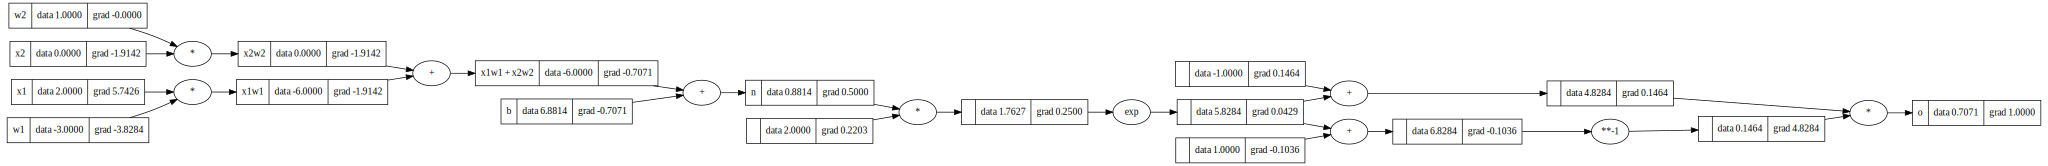

In [11]:
# inputs: x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.8813735870195432, label = 'b')

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'

# n : without activation
n = x1w1_x2w2 + b; n.label='n'

# ---
# e4=Value(2.0); e4.label='e4'
# e1 = e4*n; e1.label='e1'
# e2 = e1.exp(); e2.label='e2'
# o1 = (e2 - 1); o1.label='o1'
# o2 = (e2 + 1); o2.label='o2'
# o3 = o1/o2; o3.label='o3'

e = (2*n).exp()
o = (e - 1)/(e + 1)
# ---

o.label='o'
o.backward()
draw_dot(o)

> FIX the `__add__` back propagation error\
for `b.grad` AND `x1w1_x2w2.grad`


## Implementing Pytorch

In [12]:
import torch

In [13]:
torch.Tensor([2.0]).dtype

torch.float32

In [14]:
torch.Tensor([2.0]).double().dtype


torch.float64

pytorch assumes that leaf nodes do not requires gradients, so they have to be explicitly defined (set to `False` by default ofr efficiency reasons)

In [15]:
x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2: ', x2.grad.item())
print('w2: ', w2.grad.item())
print('x1: ', x1.grad.item())
print('w1: ', w1.grad.item())


0.7071066904050358
---
x2:  0.5000001283844369
w2:  0.0
x1:  -1.5000003851533106
w1:  1.0000002567688737


`o.item()` and `o.data.item()` will produce the same result here in pytorch

In [16]:
o.item()

0.7071066904050358

In [17]:
x2.grad.item()

0.5000001283844369

### Building neural net library (multi-layer perceptron)

- neural networks are a class of mathematical expressions.
- start with a single individual neuron

In [18]:
import random

In [19]:
class Neuron:

  def __init__(self, nin):  #nin: number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__ (self, x): # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #raw activation
    out = act.tanh()
    return out

    # list(zip(self.w, x)): pairs each w with corresponding x

  def parameters(self):
    return self.w + [self.b]

> add `__radd__` function in `class Value` similar to `__rmul__`

In [20]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.8859307141289627)

In [21]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # return outs #return element in a list
    return outs[0] if len(outs) == 1 else outs #return single calue at the last layer that only has a single neuron

  def parameters(self):
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params
    return [p for neuron in self.neurons for p in neuron.parameters()]


In [22]:
x = [2.0, 3.0]
n = Layer(2, 3) #2d neurons
n(x)

[Value(data=0.997848819207507),
 Value(data=-0.6609238615311793),
 Value(data=0.9972001279428538)]

> Defining entire MLP (multi-layer perceptron)
- layers feed into each other sequentially

In [23]:
class MLP:

  def __init__(self, nin, nouts):
    size = [nin] + nouts
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [24]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3inputs, 2layers of 4neurons, 1output
n(x)

Value(data=0.8772272196399606)

In [25]:
len(n.parameters())

41

In [26]:
# draw_dot(n(x))

Create sample dataset
> - 4 possible inputs into the neural net (xs)
- 4 desired targets/outputs (ys)

Make the Neural Net
> - how to tune weights to better predict the desired targets
- achieved through loss function
- it calculates the total performance of the neural net
- goal is to minimize the loss

Implement MSE loss
> `for ygt, yout in zip(ys, ypred)`
- ygt: ground truth
- pair ground truths with the predictions
- `zip`iterates over their tuples
- subtract each `yout` and `ygt` and square them






In [27]:
# sample dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# ypred = [n(x) for x in xs]
# ypred

In [28]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8772272196399606),
 Value(data=0.9451443908082369),
 Value(data=0.9079855042519154),
 Value(data=0.8987694554404794)]

In [29]:
# Implement MSE loss
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.015073155597334466),
 Value(data=3.783586701092747),
 Value(data=3.6404086844354357),
 Value(data=0.010247623151817091)]

> - for each of the 4 output, take prediction and ground truth, subtract then square them
- squaring ensures a positive number. (absolute value can be used instead)
- when prediction close to the target, output is close to 0

In [30]:
# Final loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.4493161642773345)

In [31]:
loss.backward()

In [32]:
# draw_dot(loss)

> - graph above has 4 forward passes of a neural net for every example. has the loss on top, and ends with value of loss.
- loss backpropagates through all forward passes and intermediate values of the neural all the way to the parameters of the weights(inputs)
- gradients on input data are not useful as they are fixed. is not changed.


### Modify Parameters to minimize loss

> - the weight and bias parameters can be changed
  - create `__parameters__` function to collect them
- negative grad = negative influence on loss.
- Slight increase in weight of this neuron in this layer minimizes the loss
  - `n.layers[0].neurons[0].w[0].grad`
  - `n.layers[0].neurons[0].w[0].data`
- Gradiesnt descent: forward pass>backward pass>update


In [33]:
# Verify change on loss
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.4493161642773345)

In [34]:
loss.backward()

In [35]:
# Modify parameters to minimize loss
for p in n.parameters():
  p.data += -0.01 * p.grad

In [36]:
ypred

[Value(data=0.8772272196399606),
 Value(data=0.9451443908082369),
 Value(data=0.9079855042519154),
 Value(data=0.8987694554404794)]

### Implement Training Loop

In [37]:
# Reset neural net

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3inputs, 2layers of 4neurons, 1output
n(x)

Value(data=-0.5885606196119877)

In [38]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# ypred = [n(x) for x in xs]
# ypred

In [42]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass:
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.5054894400708304
1 0.465908765165315
2 0.4347341022344972
3 0.3875793399008766
4 0.36918335647828865
5 0.3324490197747686
6 0.3137176515179921
7 0.2911570735647423
8 0.2741907197123754
9 0.25946009616016963
10 0.24231515443087492
11 0.23226505861137914
12 0.21774383604422476
13 0.20901244922695408
14 0.1998187779158809
15 0.1891284881974864
16 0.18218044765083916
17 0.17504984234182552
18 0.1671847963365865
19 0.1609297846964787


In [40]:
ypred

[Value(data=-0.11182998582995972),
 Value(data=-0.12089364119720722),
 Value(data=-0.45817318623764425),
 Value(data=-0.1331090547971834)]